# Studying glass classification

I'm trying to learn a bit more on 2 topics:

1. spotting and correcting skewed data
2. tuning the Random Forest Classifier parameters to achieve better results

## The data
This is the list of all the fields.

* Id number: 1 to 214 (removed from CSV file)
* RI: refractive index
* Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* Si: Silicon
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
* Type of glass: (class attribute)
  *  1 building_windows_float_processed
  * 2 building_windows_non_float_processed
  * 3 vehicle_windows_float_processed
  * 4 vehicle_windows_non_float_processed (none in this database)
  * 5 containers
  * 6 tableware
  * 7 headlamps

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Loading dataset and showing some records

In [4]:
#df = pd.read_csv('../input/glass.csv')
df = pd.read_csv('glass.csv')

df.sample(5)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
130,1.52177,13.75,1.01,1.36,72.19,0.33,11.14,0.00,0.00,2
129,1.52020,13.98,1.35,1.63,71.76,0.39,10.56,0.00,0.18,2
146,1.51769,13.65,3.66,1.11,72.77,0.11,8.60,0.00,0.00,3
200,1.51508,15.15,0.00,2.25,73.50,0.00,8.34,0.63,0.00,7
188,1.52247,14.86,2.20,2.06,70.26,0.76,9.76,0.00,0.00,7


### X and Y
Dropping the class (`Type` column) from the X set and moving it in the Y set

In [5]:
X = df.drop(['Type'], axis=1)
Y = df['Type']

How the features influence the classification

In [6]:
df.corr()['Type'].abs().sort_values(ascending=False)

Type    1.000000
Mg      0.744993
Al      0.598829
Ba      0.575161
Na      0.502898
Fe      0.188278
RI      0.164237
Si      0.151565
K       0.010054
Ca      0.000952
Name: Type, dtype: float64

### Calculating data skewness and possibly unskewing

/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:169: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


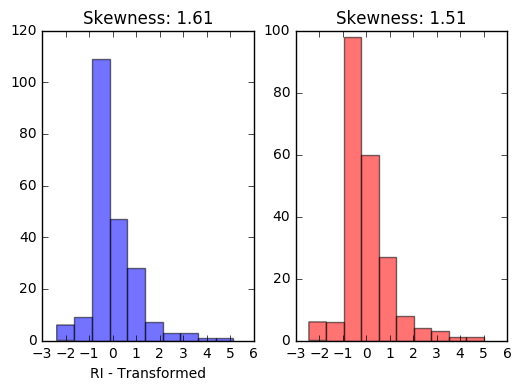

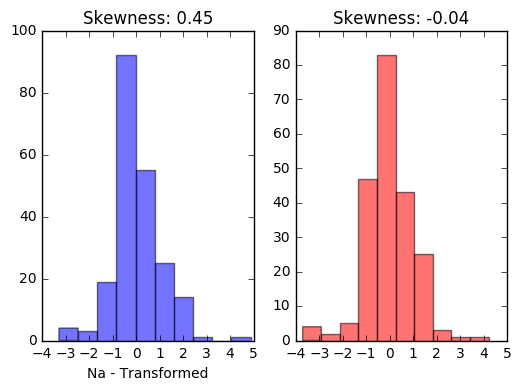

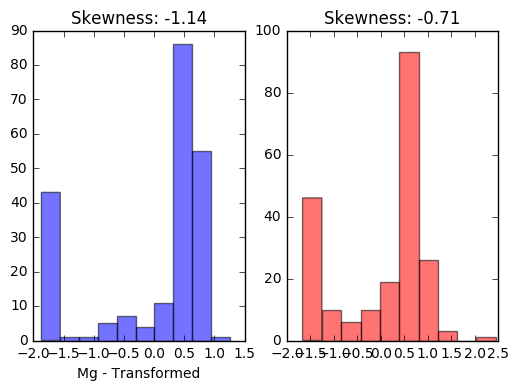

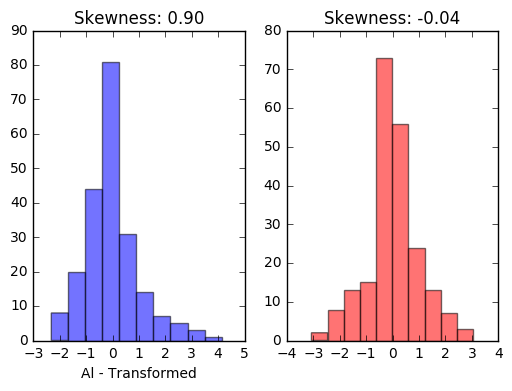

/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:152: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


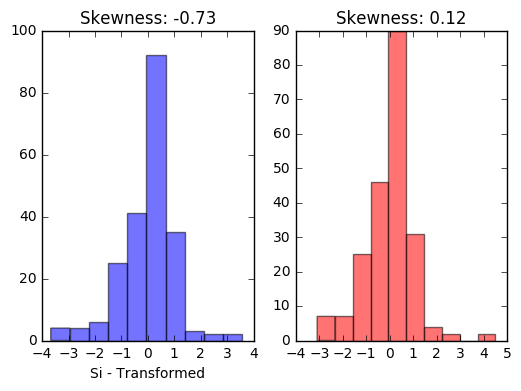

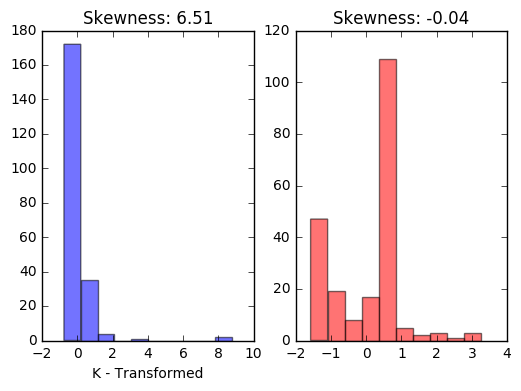

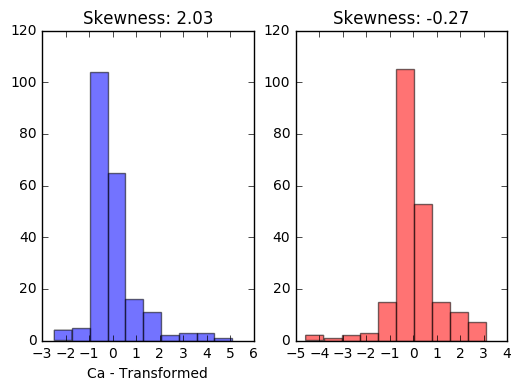

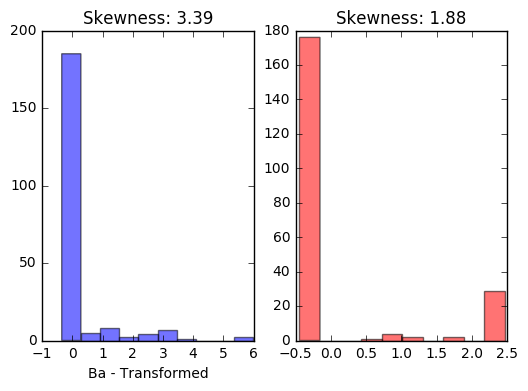

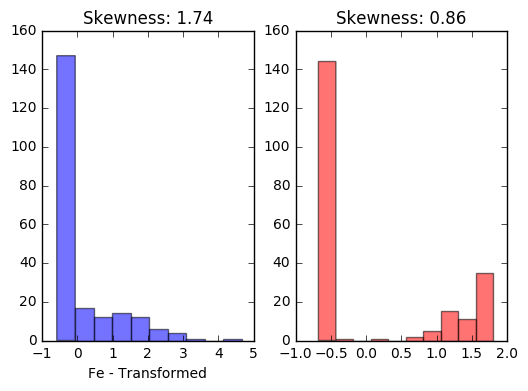

In [7]:
import matplotlib.pylab as plt
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox

# getting features names to loop
classes = X.columns.values

# This will contain the unskewed features
X_unsk = pd.DataFrame()

# looping through the 
for c in classes:
    scaled = preprocessing.scale(X[c]) 
    boxcox_scaled = preprocessing.scale(boxcox(X[c] + np.max(np.abs(X[c]) +1) )[0])
    
    # Populating 
    X_unsk[c] = boxcox_scaled
    
    #Next We calculate Skewness using skew in scipy.stats
    skness = skew(scaled)
    boxcox_skness = skew(boxcox_scaled)
    
    #We draw the histograms 
    figure = plt.figure()
    # First the original data shape
    figure.add_subplot(121)   
    plt.hist(scaled,facecolor='blue',alpha=0.55) 
    plt.xlabel(c + " - Transformed") 
    plt.title("Skewness: {0:.2f}".format(skness)) 
    
    # then the unskewed
    figure.add_subplot(122) 
    plt.hist(boxcox_scaled,facecolor='red',alpha=0.55) 
    plt.title("Skewness: {0:.2f}".format(boxcox_skness)) 

    plt.show()

In most cases the BoxCox unskewing is successfully transforming the data

## Hyperparameters

Searching the best parameters for the Random Forest Classifier 

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math

# Here I use the unskewed dataset
X = X_unsk
X_tr, X_ts, y_tr, y_ts = train_test_split(X, Y, test_size=0.40, random_state=42)

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "criterion" : ["gini", "entropy"]
              , "min_samples_leaf" : [1, 5, 10]
              , "min_samples_split" : [2, 4, 10, 12, 16]
              , "n_estimators": [100, 125, 200]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_tr, y_tr)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   17.5s finished


### Score

Printing best score performance and algorithm parameters

In [11]:
print(gs.best_score_)
print(gs.best_params_)

0.7890625
{'n_estimators': 100, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}


### Training

Final training with the best hyperparameters found by GridSearchCV

In [12]:
bp = gs.best_params_
rf = RandomForestClassifier( criterion=bp['criterion'], 
                             n_estimators=bp['n_estimators'],
                             min_samples_split=bp['min_samples_split'],
                             min_samples_leaf=bp['min_samples_leaf'],
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

rf.fit(X_tr, y_tr)
pred = rf.predict(X_ts)

score = rf.score(X_ts, y_ts)
print("Score: %.3f" % (score))

Score: 0.756


Very poor performance :(

### Features importance
This is the features importances for the algorithm

In [13]:
pd.concat((pd.DataFrame(X.columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
2,Mg,0.226017
3,Al,0.155965
0,RI,0.124578
6,Ca,0.123416
1,Na,0.121647
5,K,0.089243
4,Si,0.076683
7,Ba,0.058952
8,Fe,0.023499


Taking a look at the confusion matrix.

Confusion matrix, without normalization
[[22  4  2  0  0  0]
 [ 4 23  3  1  1  0]
 [ 2  1  2  0  0  0]
 [ 0  3  0  4  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  0  0 10]]


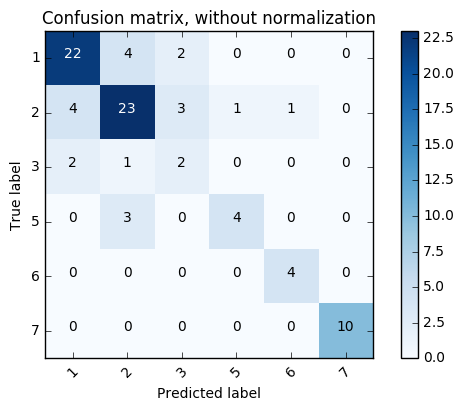

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
#print(y_ts.values)
#print(pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_ts.values, pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.sort(y_ts.unique()), normalize=False,
                      title='Confusion matrix, without normalization')

## Trying with XGBoost

As suggested in the comments, I try to compare this Random Forest model with an XGBoost to see how both perform with this dataset.

In [100]:
from xgboost import XGBClassifier

# Here I use the unskewed dataset
X = X_unsk
X_tr, X_ts, y_tr, y_ts = train_test_split(X, Y, test_size=0.4, random_state=42)
xgb = XGBClassifier()

param_grid = { "max_depth" : [5]
              , "learning_rate" : [0.1, 0.125, 0.2]
              , "n_estimators": [50, 100]
              , "reg_lambda": [.01, .1, .5]}
gs = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_tr, y_tr)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   48.0s finished


In [101]:
print(gs.best_score_)
print(gs.best_params_)

0.7421875
{'n_estimators': 50, 'max_depth': 5, 'reg_lambda': 0.1, 'learning_rate': 0.125}


The score on the TS is a bit worse than the RF even though I tried many parameters combination.

In [105]:
bp = gs.best_params_
xgb = XGBClassifier( max_depth=bp['max_depth'], 
                             n_estimators=bp['n_estimators'],
                             learning_rate=bp['learning_rate'],
                   reg_lambda=bp['reg_lambda'])

xgb.fit(X_tr, y_tr)
pred = xgb.predict(X_ts)

score = xgb.score(X_ts, y_ts)
print("Score: %.3f" % (score))

Score: 0.709


The feature importance matrix is slightly different from the RF's one.

In [106]:
pd.concat((pd.DataFrame(X.columns, columns = ['variable']), 
           pd.DataFrame(xgb.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
0,RI,0.177408
1,Na,0.176022
2,Mg,0.150381
3,Al,0.137907
6,Ca,0.135135
5,K,0.102564
4,Si,0.070686
8,Fe,0.038115
7,Ba,0.011781


Confusion matrix, without normalization
[[21  5  2  0  0  0]
 [ 3 23  1  2  1  2]
 [ 2  1  2  0  0  0]
 [ 0  5  0  2  0  0]
 [ 0  0  0  0  4  0]
 [ 0  1  0  0  0  9]]


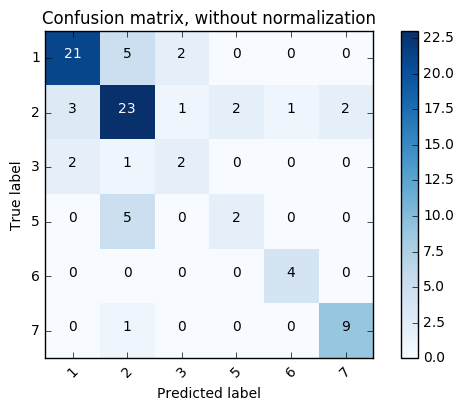

In [107]:
cnf_matrix = confusion_matrix(y_ts.values, pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.sort(y_ts.unique()), normalize=False,
                      title='Confusion matrix, without normalization')

## Conclusions

I'm really a novice in ML but I'm trying to apply all the interesting stuff I find in many awesome Kaggle kernels and discussions in order to slowly learn how work with data.

In this case I've learned a bit more about feature skewing, Random Forest parameters tuning and I did some experiment with XGBoost but the kernel is really far from defining a decent classifier for the glass classification problem. Maybe I need to study more the dataset and to try other classifiers.

Anyway, any advice is welcome!